In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torchvision
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

import copy

import matplotlib.pyplot as plt

# Import and process the data

In [2]:
### MNIST data

# import dataset
data = np.loadtxt(open('../../../Datasets/mnist_train_small.csv','rb'),delimiter=',')

# extract labels, normalize, reshape
labelsT   = torch.tensor( data[:,0] ).long()
data      = data[:,1:]
dataNorm  = data / np.max(data)
dataNormT = torch.tensor( dataNorm.reshape(dataNorm.shape[0],1,28,28) ).float()

# split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataNormT, labelsT, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 32
numbers_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
numbers_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [3]:
### FMNIST data

# transformations
transform = T.Compose([ T.ToTensor(), T.Normalize(.5,.5) ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
fashion_train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
fashion_test_loader  = DataLoader(testset, batch_size=len(testset))

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.6%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



119.3%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

    class mnistNet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            ### convolution layers
            self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
            # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

            self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
            # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

            # compute the number of units in FClayer (number of outputs of conv2)
            expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
            expectSize = 20*int(expectSize**2)

            ### fully-connected layer
            self.fc1 = nn.Linear(expectSize,50)

            ### output layer
            self.out = nn.Linear(50,10)

            # toggle for printing out tensor sizes during forward prop
            self.print = printtoggle

        # forward pass
        def forward(self,x):
      
            print(f'Input: {x.shape}') if self.print else None

            # convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x),2))
            print(f'Layer conv1: {x.shape}') if self.print else None

            # and again: convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x),2))
            print(f'Layer conv2: {x.shape}') if self.print else None

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print: print(f'Vectorize: {x.shape}')

            # linear layers
            x = F.relu(self.fc1(x))
            if self.print: print(f'Layer fc1: {x.shape}')
            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x
  
    # create the model instance
    net = mnistNet(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer (NOTE: Using SGD here to slow down learning!)
    optimizer = torch.optim.SGD(net.parameters(), lr=.005)

    return net,lossfun,optimizer

# Create a function that trains the model

In [5]:
# a function that trains the model

# input the network and the number of epochs to train
def function2trainTheModel(net,train_loader,test_loader,numepochs=10):

    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
      
        # compute test accuracy
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    # end epochs

    # function output
    return trainAcc,testAcc,losses,net


# Train the source model on numbers and show the results

In [6]:
# create a new model
numberNet,lossfun,optimizer = createTheMNISTNet()

# train it on numbers data
trainAcc,testAcc,losses,numberNet = function2trainTheModel(numberNet,numbers_train_loader,numbers_test_loader,5)

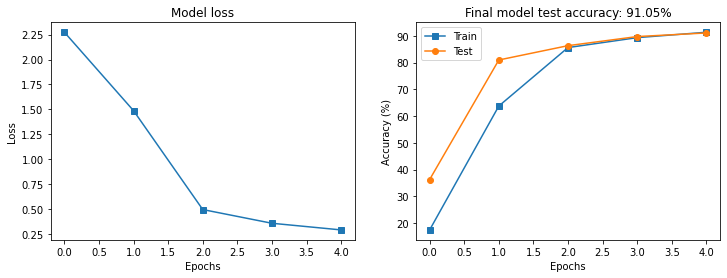

In [7]:
fig,ax = plt.subplots(1,2,figsize=(12, 4))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Test the model on the fashion data

In [8]:
# test the model with fashion data

# extract X,y from FASHION test dataloader
X,y = next(iter(fashion_test_loader))
yHat = numberNet(X)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 6.86%


# Fine-tune the model using one batch

In [9]:
## NOTE about this cell: I've added print() statements in here to show that the copying works.
## The first print function will show a non-zeros matrix because the weights of the two models
## differ. The second print function shows the zeros matrix because the two models have identical
## weights. See Q&A for this lecture.

# create the target model
fashionNet,lossfun,optimizer = createTheMNISTNet()
print( fashionNet.conv1.weight[0] - numberNet.conv1.weight[0], "\n" )

# then replace all the weights in TARGET model from SOURCE model
for target, source in zip(fashionNet.named_parameters(), numberNet.named_parameters()):
    target[1].data = copy.deepcopy( source[1].data )

print( fashionNet.conv1.weight[0] - numberNet.conv1.weight[0] )

tensor([[[ 0.0863, -0.0298,  0.0809, -0.2882, -0.0998],
         [-0.2128,  0.2372, -0.1176, -0.2642, -0.3698],
         [ 0.0423, -0.1503,  0.1923,  0.0411, -0.1886],
         [-0.1569, -0.0238, -0.0373, -0.0023, -0.1142],
         [ 0.1682,  0.3737,  0.2078,  0.2239,  0.0197]]],
       grad_fn=<SubBackward0>) 

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<SubBackward0>)


In [ ]:
# Note: you'd think that the following should work, but deepcopy() doesn't copy many features of classes.
# Try it and see what happens!
#DUDL_transfer_MNISTtoFMNIST = copy.deepcopy( numberNet )

In [10]:
# now re-train the network on the numbers data

trainAcc,testAcc,losses,fashionNet = function2trainTheModel(
                                         fashionNet, fashion_train_loader, fashion_test_loader, 1)

In [11]:
print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')

numberNet TRAIN accuracy: 67.94%
numberNet TEST accuracy: 73.96%


# Additional explorations

In [ ]:
# 1) We ran 5 epochs of training, and saw a nice boost in transfer learning. However, it looks like the initial training
#    on the numbers wasn't finished. Do you think the transfer learning boost will be higher if you train the initial
#    model longer? Test it to find out!
# 
# 2) Do transfer learning the other way around: Train the model on the fashion data, then apply it to the number data.
#    Before running the model, think about the model architecture, the nature of the images, and make a prediction about
#    whether you would expect number->fashion or fashion->number to transfer better (that is, which would have higher
#    accuracy from one epoch of training). Is your prediction confirmed?